In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Contextualização: 

Bem-vindo à Machine Learning Housing Corporation!
A primeira tarefa que lhe é atribuída é construir um modelo de preços de imóveis na Califórnia utilizando os dados do censo da Califórnia. Esses dados contêm métricas como população, renda mediana, preço mediano dos imóveis, entre outras, para cada block group da Califórnia. Block groups são a menor unidade geográfica para a qual o US Census Bureau publica dados amostrais (um block group normalmente possui uma população entre 600 e 3.000 pessoas). Vamos chamá-los simplesmente de “distritos” para simplificar. Seu modelo deve aprender a partir desses dados e ser capaz de prever o preço mediano dos imóveis em qualquer distrito, dadas todas as outras métricas disponíveis.

A primeira pergunta que você deve fazer ao seu chefe é qual é exatamente o objetivo de negócio; construir um modelo provavelmente não é o objetivo final. Como a empresa espera usar esse modelo e se beneficiar dele? Isso é importante porque determinará como você irá formular o problema, quais algoritmos irá selecionar, qual medida de desempenho usará para avaliar o modelo e quanto esforço deverá gastar ajustando-o. Seu chefe responde que a saída do seu modelo (uma previsão do preço mediano dos imóveis de um distrito) será alimentada em outro sistema de Machine Learning (ver Figura 2-2), juntamente com muitos outros sinais. Esse sistema posterior determinará se vale a pena ou não investir em uma determinada área. Acertar isso é fundamental, pois afeta diretamente a receita.

A próxima pergunta a ser feita é como é a solução atual (se existir). Ela frequentemente fornece uma referência de desempenho, além de insights sobre como resolver o problema. Seu chefe responde que, atualmente, os preços dos imóveis por distrito são estimados manualmente por especialistas: uma equipe reúne informações atualizadas sobre um distrito e, quando não consegue obter o preço mediano dos imóveis, faz uma estimativa usando regras complexas. Esse processo é caro e demorado, e as estimativas não são muito boas; nos casos em que conseguem descobrir o preço mediano real dos imóveis, frequentemente percebem que as estimativas estavam erradas em mais de 20%. É por isso que a empresa acredita que seria útil treinar um modelo para prever o preço mediano dos imóveis de um distrito com base em outros dados sobre esse distrito. Os dados do censo parecem ser um excelente conjunto de dados para explorar esse propósito, pois incluem os preços medianos dos imóveis de milhares de distritos, além de outras informações relevantes.

Muito bem, com todas essas informações você já está pronto para começar a projetar seu sistema. Primeiro, você precisa formular o problema: ele é supervisionado, não supervisionado ou de Reinforcement Learning? É uma tarefa de classificação, regressão ou outra coisa? Você deve usar técnicas de aprendizado em lote (batch learning) ou aprendizado online?

Antes de continuar a leitura, pause e tente responder a essas perguntas por conta própria.

Você encontrou as respostas? Vamos ver: trata-se claramente de uma tarefa típica de aprendizado supervisionado, já que você recebe exemplos de treinamento rotulados (cada instância vem com a saída esperada, isto é, o preço mediano dos imóveis do distrito). Além disso, é também uma tarefa típica de regressão, pois você está tentando prever um valor numérico. Mais especificamente, este é um problema de regressão múltipla, já que o sistema usará múltiplas características para fazer a previsão (como população do distrito, renda mediana etc.). Também é um problema de regressão univariada, pois estamos tentando prever apenas um único valor para cada distrito. Se estivéssemos tentando prever múltiplos valores por distrito, seria um problema de regressão multivariada. Por fim, não há um fluxo contínuo de dados entrando no sistema, não existe uma necessidade particular de se ajustar rapidamente a dados em mudança, e o conjunto de dados é pequeno o suficiente para caber na memória. Portanto, o aprendizado em lote (batch learning) simples é mais do que suficiente.

# 1. Abrindo dataset

In [8]:
housing = pd.read_csv("../datasets/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [9]:
print("Colunas do nosso dataset")
housing.columns

Colunas do nosso dataset


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

# 2. Visualizando graficamente

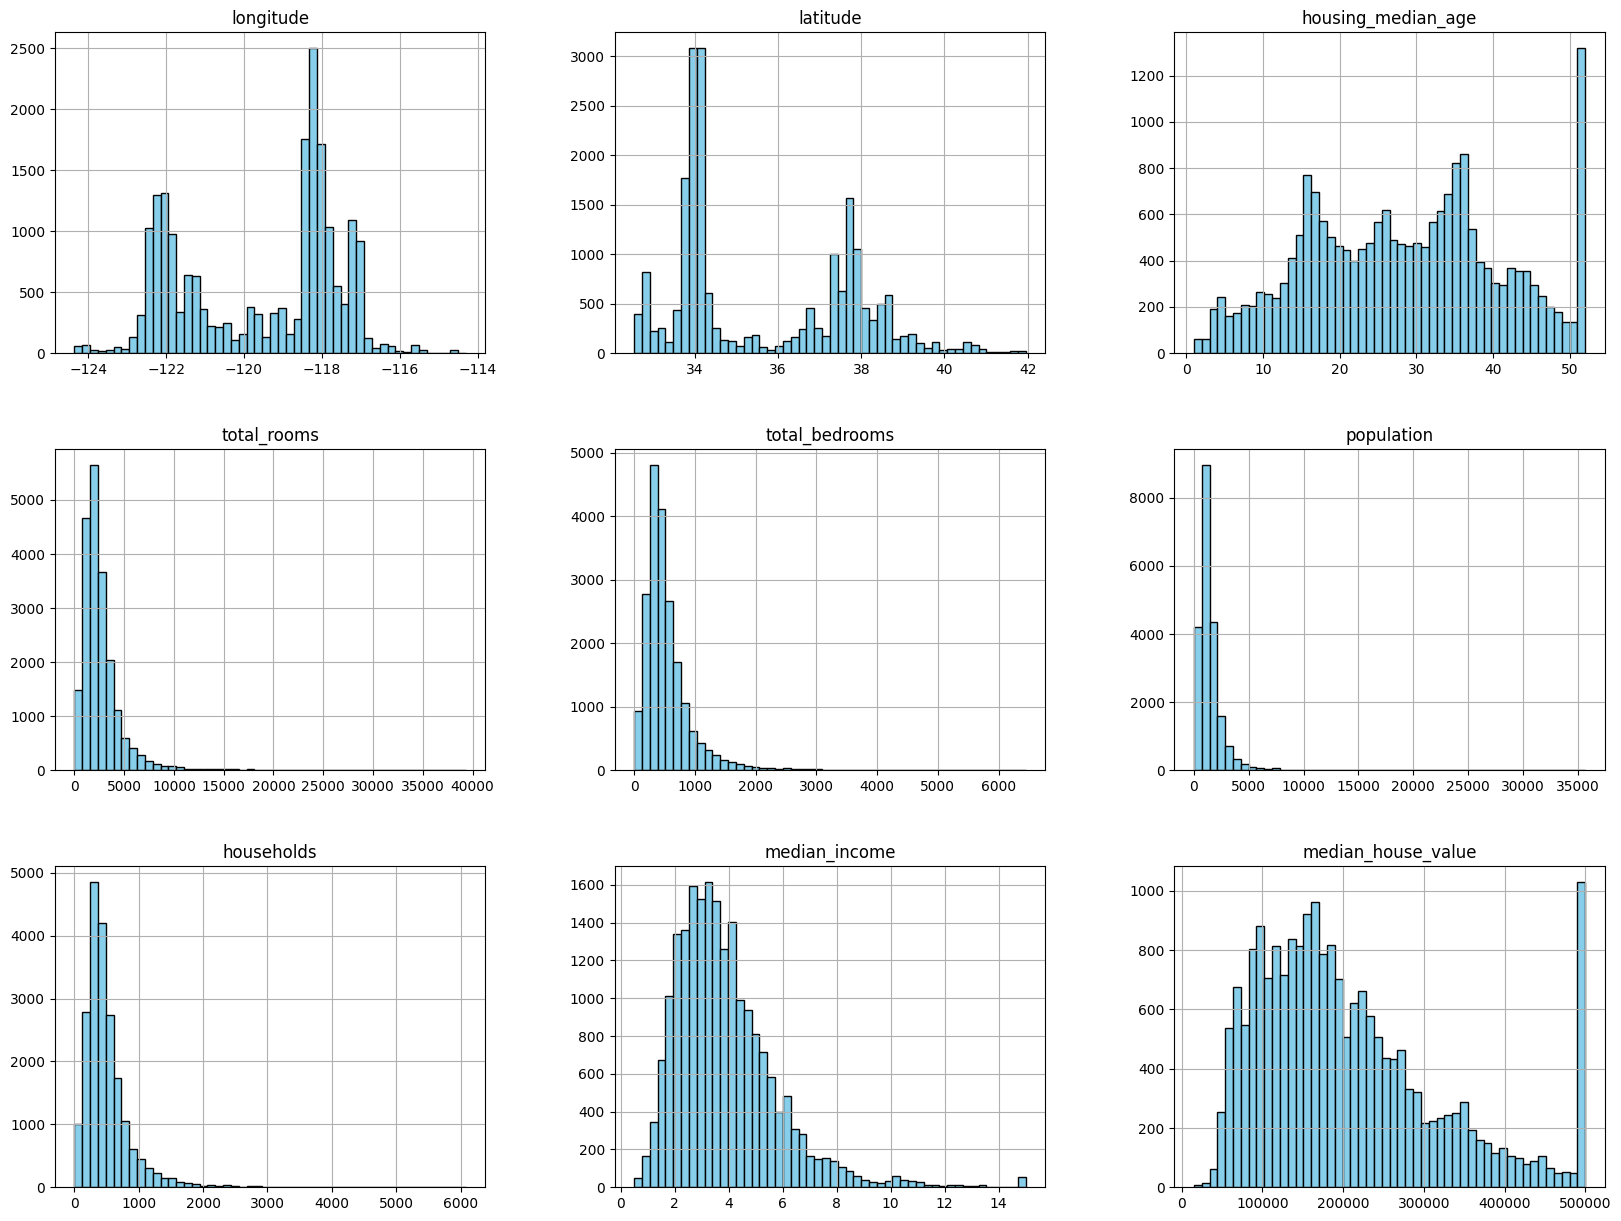

In [10]:
housing.hist(bins=50, color='skyblue', edgecolor='black', figsize=(20,15))
plt.show()

# 3. Criando um test set

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42 )

## Observação: 

O trecho acima pode gerar um viés de amostragem (sampling bias). Sampling bias acontece quando o conjunto de dados usado (especialmente o de teste) não representa bem a população real. Onde exatamente está o sampling bias? Não está no algoritmo, não está no treinamento, não está nas features, **está na forma como o test set é construído**. Utilizando o trecho acima você esta assumindo que uma amostragem aleatória será representativa mas essa suposição nesse caso não é verdadeira. E por que isso quebra a avaliação? Imagine poucas regiões ricas no teste, como casas caras são difíceis de prever e o modelo normalmente erra mais nelas, o erro médio fica artificialmente baixo, logo você acha que o modelo é ótimo mas ele só foi pouco testado onde mais erra. Agora imagine o contrário, muitas regiões ricas no teste implicam em muitas casas caras, logo muitos erros grandes, assim você acha que o modelo é ruim mas ele foi testado mais forte do que deveria. 

In [ ]:
# Vamos estratificar a feature median_income em categorias
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, float('inf')],
    labels=[1, 2, 3, 4, 5])

# 0.0 a 1.5 (15k) -> 1 
# 1.5 a 3.0 -> 2 
# 3.0 a 4.5 - > 3
# 4.5 a 6.0 -> 4 
# 6.0 a inf - > 5 
housing["income_cat"]


0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
          ...  
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: median_income, Length: 20640, dtype: float64

In [26]:
housing[housing["income_cat"] == 1].count()

longitude             822
latitude              822
housing_median_age    822
total_rooms           822
total_bedrooms        814
population            822
households            822
median_income         822
median_house_value    822
ocean_proximity       822
income_cat            822
dtype: int64

Text(0.5, 0, 'Category')

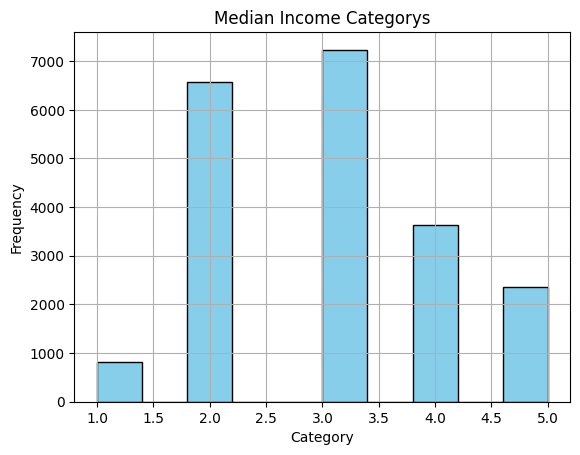

In [22]:
housing["income_cat"].hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Median Income Categorys")
plt.ylabel("Frequency")
plt.xlabel("Category")

In [ ]:
# Utilizando o StratifiedShuffleSplit, um gerador de índices de treino e teste 
# que garante que a distribuição de uma variável categórica seja preservada nos dois conjuntos.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# n_splits=1 -> Crie uma única divisão treino–teste


# o Oétodo split recebe o as features (housing) e a variável para estratificação (housing["income_cat"])
# O método split retorna um iterador (generator) de pares (train_idx, test_idx) onde cada um é um array de índices inteiros
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]


[12655 15502  2908 ... 19263 19140 19773]


<Axes: xlabel='longitude', ylabel='latitude'>

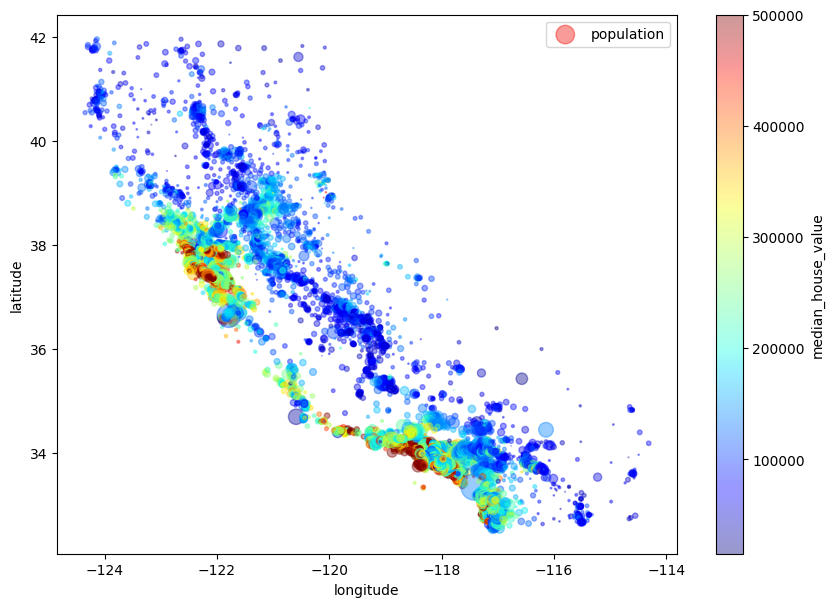

In [59]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)